<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/CIFAR100_CL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training on Split

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt
from PIL import Image
import copy 
import os
import argparse
import sys
import random
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def seed_everything(seed=12):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_args():
    parser = argparse.ArgumentParser(description='CIFAR-10H Training')
    parser.add_argument('--lr', default=0.1, type=float, help='learning rate')
    parser.add_argument('--lr_schedule', default=0, type=int, help='lr scheduler')
    parser.add_argument('--batch_size', default=256, type=int, help='batch size')
    parser.add_argument('--test_batch_size', default=2048, type=int, help='batch size')
    parser.add_argument('--num_epoch', default=200, type=int, help='epoch number')
    parser.add_argument('--num_classes', type=int, default=100, help='number classes')
    parser.add_argument('-warm', type=int, default=1, help='warm up training phase')
    #Hyperparameters for CL
    parser.add_argument('--init_ratio', default=0.80, type=float, help='initial data ratio')
    parser.add_argument('--end_epoch', default=10, type=float, help='End epoch')
    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    return args

def train(model, trainloader, criterion, optimizer, epoch, warm, warmup_scheduler):
    model.train()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if epoch <= warm:
            warmup_scheduler.step()

def test(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return correct / total

class WarmUpLR(_LRScheduler):
    """
        optimizer: optimzier(e.g. SGD)
        total_iters: totoal_iters of warmup phase
    """
    def __init__(self, optimizer, total_iters, last_epoch=-1):

        self.total_iters = total_iters
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [base_lr * self.last_epoch / (self.total_iters + 1e-8) for base_lr in self.base_lrs]

class CELossWithLS(torch.nn.Module):
    def __init__(self, classes=None, ls_factor=0.1, ignore_index=-1):
        super(CELossWithLS, self).__init__()
        self.ls_factor = ls_factor
        self.complement = 1.0 - self.ls_factor
        self.cls = classes
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
        self.ignore_index = ignore_index

    def forward(self, logits, target):
        with torch.no_grad():
            oh_labels = F.one_hot(target.to(torch.int64), num_classes = self.cls).contiguous()
            smoothen_ohlabel = oh_labels * self.complement + self.ls_factor / self.cls
        logs = self.log_softmax(logits[target!=self.ignore_index])
        return -torch.sum(logs * smoothen_ohlabel[target!=self.ignore_index], dim=1).mean()

class CIFAR100_TrainValid(torchvision.datasets.CIFAR100):

    def __init__(self, root, istrain=True, train=True, transform=None,
                 download=False):
        super(CIFAR100_TrainValid, self).__init__(root=root, train=train, download=download, transform=transform) 
        self.transform = transform
        if istrain:
            self.data, self.targets = self.data[:40000], self.targets[:40000]            
        else:
            self.data, self.targets = self.data[40000:], self.targets[40000:]

        #hist = np.histogram(self.targets, bins=100, range=(0,100))[0]
        # plt.bar(np.arange(len(hist)),hist)
        # plt.savefig('cifar100_train_{}.png'.format(int(train)))

    def __getitem__(self, index: int):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img, target


def main():
    seed_everything()
    args = get_args()
    mean_cifar100, std_cifar100 = (0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)
    transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(), transforms.ToTensor(),
                transforms.Normalize(mean_cifar100, std_cifar100), ])
    transform_test = transforms.Compose([transforms.ToTensor(),
        transforms.Normalize(mean_cifar100, std_cifar100),])

    # train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
    # test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
    train_dataset = CIFAR100_TrainValid(root='./data', istrain=True, download=True, transform=transform_train)
    test_dataset = CIFAR100_TrainValid(root='./data', istrain=False, download=True, transform=transform_test)

    train_loader_split = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True,num_workers=2)
    test_loader_split = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=False, num_workers=2)
    
    model = models.resnet34(pretrained=True).to(device)

    #Modify the pre-existing Resnet architecture from TorchVision. The pre-existing architecture is based on ImageNet 
    #images (224x224) as input. So we need to modify it for CIFAR10 images (32x32).
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.fc = nn.Linear(model.fc.in_features, args.num_classes)
    model = model.to(device)

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=5e-4)
    #criterion = nn.CrossEntropyLoss()
    criterion = CELossWithLS(classes=args.num_classes, ls_factor=0.1)
    train_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2) #learning rate decay
    iter_per_epoch = len(train_loader_split)
    warmup_scheduler = WarmUpLR(optimizer, iter_per_epoch * args.warm)

    best_epoch, best_acc = 0.0, 0
    for epoch in range(1, args.num_epoch + 1):
        if epoch > args.warm:
            train_scheduler.step()
        train(model, train_loader_split, criterion, optimizer, epoch, args.warm, warmup_scheduler)
        accuracy = test(model, test_loader_split)
        if accuracy > best_acc:
            best_acc = accuracy
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model_cifar100.pth.tar')
        print('epoch: {}  acc: {:.4f}  best epoch: {}  best acc: {:.4f}, lr: {:.4f}'.format(
                epoch, accuracy, best_epoch, best_acc, optimizer.param_groups[0]['lr']))

In [ ]:
main()

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

epoch: 1  acc: 0.1897  best epoch: 1  best acc: 0.1897, lr: 0.1000
epoch: 2  acc: 0.3442  best epoch: 2  best acc: 0.3442, lr: 0.1000
epoch: 3  acc: 0.4179  best epoch: 3  best acc: 0.4179, lr: 0.1000
epoch: 4  acc: 0.1029  best epoch: 3  best acc: 0.4179, lr: 0.1000
epoch: 5  acc: 0.4403  best epoch: 5  best acc: 0.4403, lr: 0.1000
epoch: 6  acc: 0.4898  best epoch: 6  best acc: 0.4898, lr: 0.1000
epoch: 7  acc: 0.4741  best epoch: 6  best acc: 0.4898, lr: 0.1000
epoch: 8  acc: 0.4910  best epoch: 8  best acc: 0.4910, lr: 0.1000
epoch: 9  acc: 0.5267  best epoch: 9  best acc: 0.5267, lr: 0.1000
epoch: 10  acc: 0.5519  best epoch: 10  best acc: 0.5519, lr: 0.1000
epoch: 11  acc: 0.5313  best epoch: 10  best acc: 0.5519, lr: 0.1000
epoch: 12  acc: 0.4873  best epoch: 10  best acc: 0.5519, lr: 0.1000
epoch: 13  acc: 0.2754  best epoch: 10  best acc: 0.5519, lr: 0.1000
epoch: 14  acc: 0.4857  best epoch: 10  best acc: 0.5519, lr: 0.1000
epoch: 15  acc: 0.5478  best epoch: 10  best acc: 0.

# Curriculum Learning

In [2]:
class CELossWithLS(torch.nn.Module):
    def __init__(self, classes=None, ls_factor=0.1, ignore_index=-1):
        super(CELossWithLS, self).__init__()
        self.ls_factor = ls_factor
        self.complement = 1.0 - self.ls_factor
        self.cls = classes
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
        self.ignore_index = ignore_index

    def forward(self, logits, target):
        with torch.no_grad():
            oh_labels = F.one_hot(target.to(torch.int64), num_classes = self.cls).contiguous()
            smoothen_ohlabel = oh_labels * self.complement + self.ls_factor / self.cls
        logs = self.log_softmax(logits[target!=self.ignore_index])
        return -torch.sum(logs * smoothen_ohlabel[target!=self.ignore_index], dim=1)


def get_threshold_confidence(model_rank, trainloader_rank, init_ratio=0.80):  
    conf_list_all = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(trainloader_rank):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_rank(inputs)
            conf = F.softmax(outputs, dim=1)
            conf_list = [conf_each[targets[i]] for i, conf_each in enumerate(conf)]
            conf_list_all.extend(torch.tensor(conf_list))

    conf_list_all = torch.tensor(conf_list_all)
    sample_total = len(conf_list_all)
    for mu in np.arange(1, 0, -0.001):
        sample_mu = len(conf_list_all[conf_list_all>mu])
        ratio = sample_mu / sample_total
        if ratio >= init_ratio:
            break

    return mu, conf_list_all


class CIFAR100_MC(torchvision.datasets.CIFAR100):
    def __init__(self, root, train=True, transform=None, download=False, model_confidence=None):
        super(CIFAR100_MC, self).__init__(root=root, train=train, download=download, transform=transform) 
        self.transform = transform
        self.train = train
        if self.train:
            self.mc = model_confidence

    def __getitem__(self, index: int):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)

        if self.train:
            return img, target, self.mc[index]
        else:
            return img, target

def train(model, model_rank, trainloader, criterion, optimizer, epoch, warmup_scheduler, args):
    model.train()
    for batch_idx, (inputs, targets, conf_list) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)[conf_list>args.mu].mean()
        loss.backward()
        optimizer.step()
        if epoch <= args.warm:
            warmup_scheduler.step()

def main():
    seed_everything()
    args = get_args()

    ##### main model to train with CL######
    model = models.resnet34(pretrained=True).to(device)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.fc = nn.Linear(model.fc.in_features, args.num_classes)
    model.to(device)

    ##### Ranking model and dataloader for CL######
    model_rank = copy.deepcopy(model)
    model_rank.load_state_dict(torch.load('best_model_cifar100.pth.tar'))
    model_rank.to(device)
    model_rank.eval()

    mean_cifar100, std_cifar100 = (0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)
    transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(), transforms.ToTensor(),
                transforms.Normalize(mean_cifar100, std_cifar100), ])
    transform_test = transforms.Compose([transforms.ToTensor(),
        transforms.Normalize(mean_cifar100, std_cifar100),])

    train_dataset_rank = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_test)
    train_loader_rank = torch.utils.data.DataLoader(train_dataset_rank, batch_size=args.test_batch_size, shuffle=False, num_workers=2)

    ##### Hyperparameters for CL######
    args.init_ratio = 0.90
    args.end_epoch = 10
    args.mu, conf_list_all = get_threshold_confidence(model_rank, train_loader_rank, init_ratio=args.init_ratio)
    args.mu = 0 if args.init_ratio == 1 else args.mu
    beta = args.mu / args.end_epoch
    print('Init ratio:{}, end epoch:{}, mu:{:.4f}, beta:{:.4f}'.format(args.init_ratio, args.end_epoch, args.mu, beta))

    ##### Dataloaders ####
    train_dataset = CIFAR100_MC(root='./data', train=True, download=True, transform=transform_train, model_confidence=conf_list_all)
    test_dataset = CIFAR100_MC(root='./data', train=False, download=True, transform=transform_test)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=False, num_workers=2)
    print('Sample size: Training:{}, Valid:{}'.format(len(train_dataset), len(test_dataset)))

    ##### Optimizers and scheduler####
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=5e-4)
    criterion = CELossWithLS(classes=args.num_classes, ls_factor=0.1)
    train_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2) #learning rate decay
    iter_per_epoch = len(train_loader)
    warmup_scheduler = WarmUpLR(optimizer, iter_per_epoch * args.warm)

    ##### Trainer####
    best_epoch, best_acc = 0.0, 0
    for epoch in range(1, args.num_epoch + 1):
        if epoch > args.warm:
            train_scheduler.step()
        train(model, model_rank, train_loader, criterion, optimizer, epoch, warmup_scheduler, args)

        if epoch <= args.end_epoch:
            args.mu -= beta
            args.mu = max(args.mu, 0)
        else:
            args.mu = 0

        accuracy = test(model, test_loader)
        if accuracy > best_acc:
            best_acc = accuracy
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model_cifar100_cl.pth.tar')

        print('epoch:{}  acc:{:.4f}  best epoch:{}  best acc:{:.4f}, lr:{:.4f}, mu:{:.4f}'.format(
                epoch, accuracy, best_epoch, best_acc, optimizer.param_groups[0]['lr'], args.mu))

main()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Init ratio:0.9, end epoch:10, mu:0.8590, beta:0.0859
Files already downloaded and verified
Files already downloaded and verified
Sample size: Training:50000, Valid:10000
epoch:1  acc:0.2287  best epoch:1  best acc:0.2287, lr:0.1000, mu:0.7731
epoch:2  acc:0.3728  best epoch:2  best acc:0.3728, lr:0.1000, mu:0.6872
epoch:3  acc:0.4528  best epoch:3  best acc:0.4528, lr:0.1000, mu:0.6013
epoch:4  acc:0.4890  best epoch:4  best acc:0.4890, lr:0.1000, mu:0.5154
epoch:5  acc:0.4186  best epoch:4  best acc:0.4890, lr:0.1000, mu:0.4295
epoch:6  acc:0.4552  best epoch:4  best acc:0.4890, lr:0.1000, mu:0.3436
epoch:7  acc:0.5456  best epoch:7  best acc:0.5456, lr:0.1000, mu:0.2577
epoch:8  acc:0.5203  best epoch:7  best acc:0.5456, lr:0.1000, mu:0.1718
epoch:9  acc:0.5520  best epoch:9  best acc:0.5520, lr:0.1000, mu:0.0859
epoch:10  acc:0.5591  best epoch:10  best acc:0.5591, lr:0.1000, mu:0.0000
epoch:11  acc:0.5493  best epoch:10  best acc:

In [ ]:
args.init_ratio = 0.80, args.end_epoch = 10, epoch:200  acc:0.7291  best epoch:164  best acc:0.7313, lr:0.0008, mu:0.0000
args.init_ratio = 0.90, args.end_epoch = 20, epoch:200  acc:0.7011  best epoch:164  best acc:0.7073, lr:0.0008, mu:0.0000
args.init_ratio = 0.90, args.end_epoch = 10, epoch:200  acc:0.7312  best epoch:197  best acc:0.7325, lr:0.0008, mu:0.0000

# Code testing without CL (init_ratio=100%)

In [ ]:
class CELossWithLS(torch.nn.Module):
    def __init__(self, classes=None, ls_factor=0.1, ignore_index=-1):
        super(CELossWithLS, self).__init__()
        self.ls_factor = ls_factor
        self.complement = 1.0 - self.ls_factor
        self.cls = classes
        self.log_softmax = torch.nn.LogSoftmax(dim=1)
        self.ignore_index = ignore_index

    def forward(self, logits, target):
        with torch.no_grad():
            oh_labels = F.one_hot(target.to(torch.int64), num_classes = self.cls).contiguous()
            smoothen_ohlabel = oh_labels * self.complement + self.ls_factor / self.cls
        logs = self.log_softmax(logits[target!=self.ignore_index])
        return -torch.sum(logs * smoothen_ohlabel[target!=self.ignore_index], dim=1)


def get_threshold_confidence(model_rank, trainloader_rank, init_ratio=0.80):  
    conf_list_all = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(trainloader_rank):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model_rank(inputs)
            conf = F.softmax(outputs, dim=1)
            conf_list = [conf_each[targets[i]] for i, conf_each in enumerate(conf)]
            conf_list_all.extend(torch.tensor(conf_list))

    conf_list_all = torch.tensor(conf_list_all)
    sample_total = len(conf_list_all)
    for mu in np.arange(1, 0, -0.001):
        sample_mu = len(conf_list_all[conf_list_all>mu])
        ratio = sample_mu / sample_total
        if ratio >= init_ratio:
            break

    return mu, conf_list_all


class CIFAR100_MC(torchvision.datasets.CIFAR100):
    def __init__(self, root, train=True, transform=None, download=False, model_confidence=None):
        super(CIFAR100_MC, self).__init__(root=root, train=train, download=download, transform=transform) 
        self.transform = transform
        self.train = train
        if self.train:
            self.mc = model_confidence

    def __getitem__(self, index: int):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)

        if self.train:
            return img, target, self.mc[index]
        else:
            return img, target

def train(model, model_rank, trainloader, criterion, optimizer, epoch, warmup_scheduler, args):
    model.train()
    for batch_idx, (inputs, targets, conf_list) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)[conf_list>args.mu].mean()
        loss.backward()
        optimizer.step()
        if epoch <= args.warm:
            warmup_scheduler.step()

def main():
    seed_everything()
    args = get_args()

    ##### main model to train with CL######
    model = models.resnet34(pretrained=True).to(device)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    model.fc = nn.Linear(model.fc.in_features, args.num_classes)
    model.to(device)

    ##### Ranking model and dataloader for CL######
    model_rank = copy.deepcopy(model)
    model_rank.load_state_dict(torch.load('best_model_cifar100.pth.tar'))
    model_rank.to(device)
    model_rank.eval()

    mean_cifar100, std_cifar100 = (0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)
    transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(), transforms.ToTensor(),
                transforms.Normalize(mean_cifar100, std_cifar100), ])
    transform_test = transforms.Compose([transforms.ToTensor(),
        transforms.Normalize(mean_cifar100, std_cifar100),])

    train_dataset_rank = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_test)
    train_loader_rank = torch.utils.data.DataLoader(train_dataset_rank, batch_size=args.test_batch_size, shuffle=False, num_workers=2)

    ##### Hyperparameters for CL######
    args.init_ratio = 1#0.80
    args.end_epoch = 10
    args.mu, conf_list_all = get_threshold_confidence(model_rank, train_loader_rank, init_ratio=args.init_ratio)
    args.mu = 0 if args.init_ratio == 1 else args.mu
    beta = args.mu / args.end_epoch
    print('Init ratio:{}, end epoch:{}, mu:{:.4f}, beta:{:.4f}'.format(args.init_ratio, args.end_epoch, args.mu, beta))

    ##### Dataloaders ####
    train_dataset = CIFAR100_MC(root='./data', train=True, download=True, transform=transform_train, model_confidence=conf_list_all)
    test_dataset = CIFAR100_MC(root='./data', train=False, download=True, transform=transform_test)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=False, num_workers=2)
    print('Sample size: Training:{}, Valid:{}'.format(len(train_dataset), len(test_dataset)))

    ##### Optimizers and scheduler####
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=5e-4)
    criterion = CELossWithLS(classes=args.num_classes, ls_factor=0.1)
    train_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2) #learning rate decay
    iter_per_epoch = len(train_loader)
    warmup_scheduler = WarmUpLR(optimizer, iter_per_epoch * args.warm)

    ##### Trainer####
    best_epoch, best_acc = 0.0, 0
    for epoch in range(1, args.num_epoch + 1):
        if epoch > args.warm:
            train_scheduler.step()
        train(model, model_rank, train_loader, criterion, optimizer, epoch, warmup_scheduler, args)

        if epoch <= args.end_epoch:
            args.mu -= beta
            args.mu = max(args.mu, 0)
        else:
            args.mu = 0

        accuracy = test(model, test_loader)
        if accuracy > best_acc:
            best_acc = accuracy
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_model_cifar100_base.pth.tar')

        print('epoch:{}  acc:{:.4f}  best epoch:{}  best acc:{:.4f}, lr:{:.4f}, mu:{:.4f}'.format(
                epoch, accuracy, best_epoch, best_acc, optimizer.param_groups[0]['lr'], args.mu))

main()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Init ratio:1, end epoch:10, mu:0.0000, beta:0.0000
Files already downloaded and verified
Files already downloaded and verified
Sample size: Training:50000, Valid:10000
epoch:1  acc:0.1559  best epoch:1  best acc:0.1559, lr:0.1000, mu:0.0000
epoch:2  acc:0.3633  best epoch:2  best acc:0.3633, lr:0.1000, mu:0.0000
epoch:3  acc:0.3923  best epoch:3  best acc:0.3923, lr:0.1000, mu:0.0000
epoch:4  acc:0.4838  best epoch:4  best acc:0.4838, lr:0.1000, mu:0.0000
epoch:5  acc:0.5183  best epoch:5  best acc:0.5183, lr:0.1000, mu:0.0000
epoch:6  acc:0.4259  best epoch:5  best acc:0.5183, lr:0.1000, mu:0.0000
epoch:7  acc:0.5494  best epoch:7  best acc:0.5494, lr:0.1000, mu:0.0000
epoch:8  acc:0.4768  best epoch:7  best acc:0.5494, lr:0.1000, mu:0.0000
epoch:9  acc:0.5561  best epoch:9  best acc:0.5561, lr:0.1000, mu:0.0000
epoch:10  acc:0.5554  best epoch:9  best acc:0.5561, lr:0.1000, mu:0.0000
epoch:11  acc:0.5396  best epoch:9  best acc:0.55

# Ablation Study

In [ ]:
seed_everything()
args = get_args()
import copy 
model = models.resnet34(pretrained=True).to(device)
model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
model.fc = nn.Linear(model.fc.in_features, args.num_classes)
model.to(device)

model_rank = copy.deepcopy(model)
model_rank.load_state_dict(torch.load('best_model_cifar100.pth.tar'))
model_rank.to(device)
model_rank.eval()

mean_cifar100, std_cifar100 = (0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762)
transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(), transforms.ToTensor(),
            transforms.Normalize(mean_cifar100, std_cifar100), ])
transform_test = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize(mean_cifar100, std_cifar100),])

train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True,num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=False, num_workers=2)
with torch.no_grad():
    total, correct = 0, 0
    conf_list_all = []
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_rank(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        conf = F.softmax(outputs, dim=1)
        conf_list = [conf_each[targets[i]] for i, conf_each in enumerate(conf)]
        conf_list_all.extend(conf_list)
acc = correct / total
print('Acc:',acc,, 'len:',len(conf_list_all))

import matplotlib.pyplot as plt
conf_list_all = torch.tensor(conf_list_all)
hist, range_val = np.histogram(conf_list_all, bins=10, range=(0,1))
plt.bar(np.arange(len(hist)),hist)
plt.xticks(ticks=np.arange(len(range_val)), labels=range_val);

init_ratio = 0.80
for mu in np.arange(1, 0, -0.001):
    ratio = len(conf_list_all[conf_list_all>mu]) / len(conf_list_all)
    if ratio >= init_ratio:
        break
    
print('mu for desired intit ratio:', mu)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified
0.93864 50000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


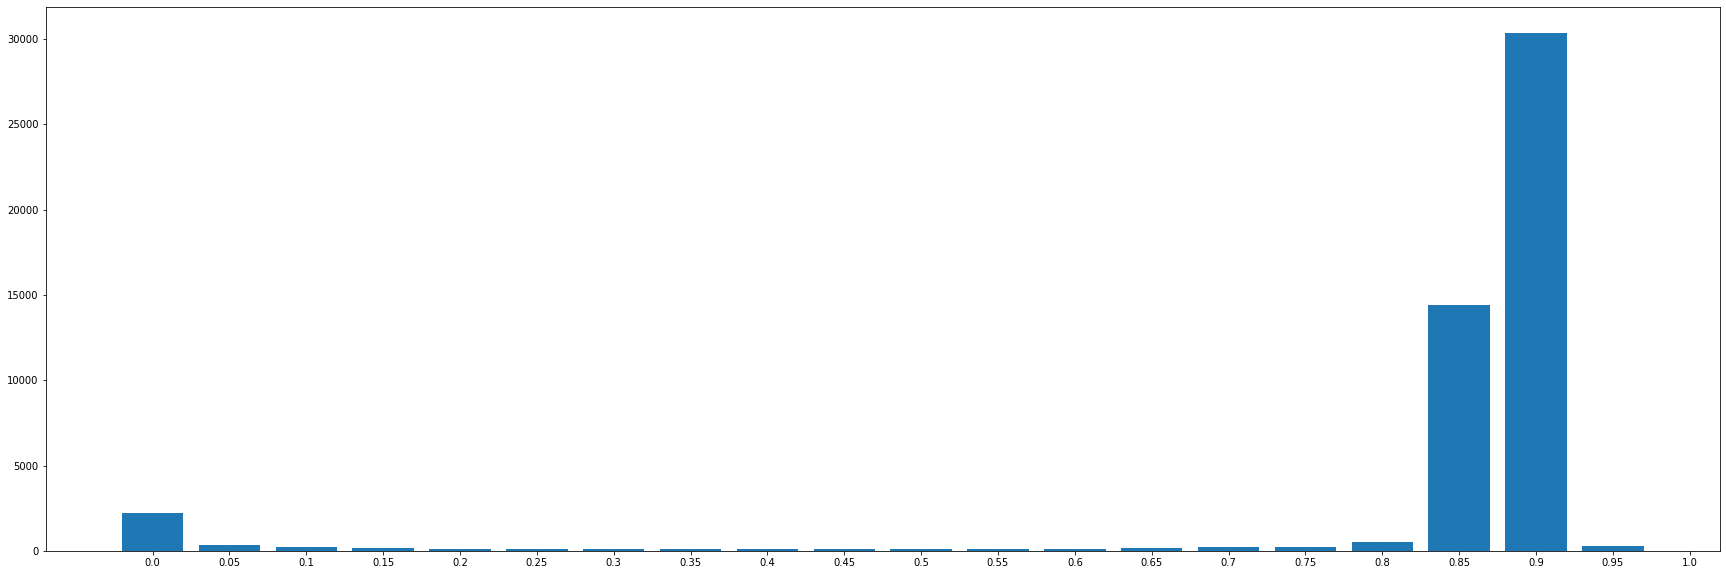

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
conf_list_all = torch.tensor(conf_list_all)
hist, range_val = np.histogram(conf_list_all, bins=20, range=(0,1))
plt.bar(np.arange(len(hist)),hist)
plt.xticks(ticks=np.arange(len(range_val)), labels=range_val);
#plt.xticklabels(range_val)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


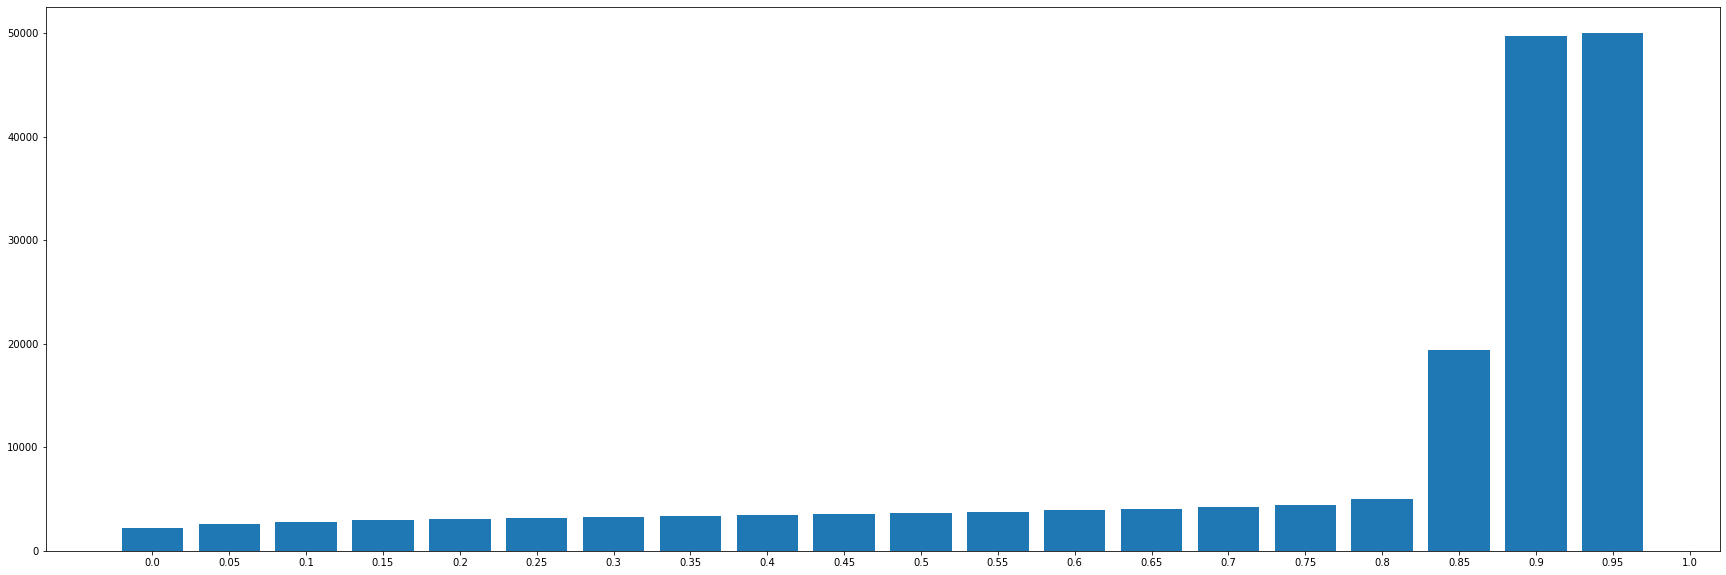

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
conf_list_all = torch.tensor(conf_list_all)
hist, range_val = np.histogram(conf_list_all, bins=20, range=(0,1))

count_bin = np.zeros(len(hist))
prev = 0
for idx in range(0, len(hist)):
    count_bin[idx] = prev + hist[idx]
    prev = count_bin[idx]

plt.bar(np.arange(len(hist)),count_bin)
plt.xticks(ticks=np.arange(len(range_val)), labels=range_val);

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


[50000. 47773. 47406. 47202. 47059. 46952. 46843. 46733. 46634. 46556.
 46450. 46345. 46229. 46099. 45960. 45765. 45531. 45023. 30601.   253.]


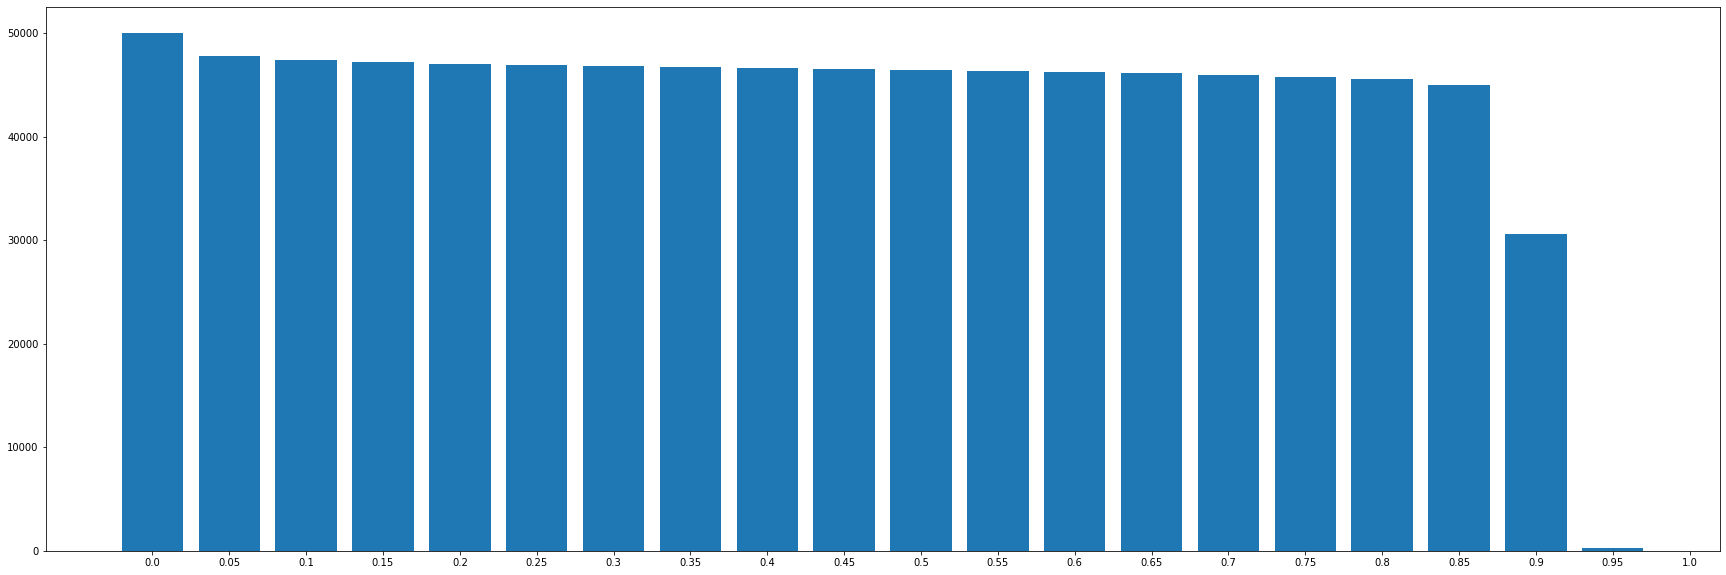

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
conf_list_all = torch.tensor(conf_list_all)
hist, range_val = np.histogram(conf_list_all, bins=20, range=(0,1))

count_bin = np.zeros(len(hist))
prev = 0
for idx in range(len(hist)-1, -1, -1):
    count_bin[idx] = prev + hist[idx]
    prev = count_bin[idx]

print(count_bin)
plt.bar(np.arange(len(hist)),count_bin)
plt.xticks(ticks=np.arange(len(range_val)), labels=range_val);

In [ ]:
init = 0.88
for i in range(10):
    init = init * 0.8
    print(i, init)

0 0.7040000000000001
1 0.5632
2 0.45056000000000007
3 0.3604480000000001
4 0.28835840000000007
5 0.23068672000000007
6 0.18454937600000007
7 0.14763950080000007
8 0.11811160064000006
9 0.09448928051200006


In [ ]:
import numpy as np
import math
#out = 0.000001 / pow(0.88,10)
(0.1/0.88)**(1/3), (1e-16/0.88)**(1/3)

(0.4843646530757322, 4.843646530757324e-06)

In [ ]:
mu = 0.88
b1 = (0.1/0.88)**(1/3)
b2 = (1e-5/0.88)**(1/3)
for i in range(10):
    mu = mu*b1
    print(mu)

0.42624089470664434
0.20645602309127348
0.10000000000000003
0.048436465307573236
0.02346091171491745
0.011363636363636371
0.005504143784951505
0.0026660126948769834
0.001291322314049588
0.0006254708846535804
